# DMD EDA

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from collections import defaultdict
from pathlib import Path
from pprint import pprint
from typing import Any

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

from model.dmd import (
    DRIVER_SESSION_MAPPING,
    ROOT,
    get_frame_paths,
)

plt.rcParams['font.size'] = 16

## List training and test data

In [2]:
data = defaultdict(dict)

for driver, sessions in DRIVER_SESSION_MAPPING.items():
    for session in sessions:
        session = ROOT / session
        data[driver][session.name + '_normal'] = len(
            get_frame_paths(session, 'normal', 'rgb', 'jpg')
        )
        data[driver][session.name + '_anomal'] = len(
            get_frame_paths(session, 'anomal', 'rgb', 'jpg')
        )

In [3]:
pprint(data)

defaultdict(<class 'dict'>,
            {1: {'gA_1_s1_2019-03-08T09;31;15+01;00_anomal': 2892,
                 'gA_1_s1_2019-03-08T09;31;15+01;00_normal': 3870,
                 'gA_1_s2_2019-03-08T09;21;03+01;00_anomal': 10284,
                 'gA_1_s2_2019-03-08T09;21;03+01;00_normal': 3349,
                 'gA_1_s3_2019-03-14T14;31;08+01;00_anomal': 653,
                 'gA_1_s3_2019-03-14T14;31;08+01;00_normal': 1185,
                 'gA_1_s4_2019-03-22T11;49;58+01;00_anomal': 13197,
                 'gA_1_s4_2019-03-22T11;49;58+01;00_normal': 3111,
                 'gA_1_s5_2019-03-14T14;26;17+01;00_anomal': 349,
                 'gA_1_s5_2019-03-14T14;26;17+01;00_normal': 5078,
                 'gA_1_s6_2019-03-08T09;15;15+01;00_anomal': 2369,
                 'gA_1_s6_2019-03-08T09;15;15+01;00_normal': 2964,
                 'gA_1_s6_2019-03-22T11;59;56+01;00_anomal': 2572,
                 'gA_1_s6_2019-03-22T11;59;56+01;00_normal': 2998},
             2: {'gA_2_s1_2019-03

In [4]:
table_data = defaultdict(dict)

for driver, driver_data in data.items():
    for session, frames in driver_data.items():
        if 's1' in session:
            if 'normal' in session:
                table_data[driver]['test_normal'] = frames
            else:
                table_data[driver]['test_anomal'] = frames
        else:
            if 'normal' in session:
                if 'train_normal' in table_data[driver]:
                    table_data[driver]['train_normal'] += frames
                else:
                    table_data[driver]['train_normal'] = frames
            else:
                pass
                # if 'train_anomal' in table_data[driver]:
                #     table_data[driver]['train_anomal'] += frames
                # else:
                #     table_data[driver]['train_anomal'] = frames

table_data_tab = {}
table_data_tab[''] = [
    'Train samples',
    'Test negative samples',
    'Test positive samples',
]
for driver, driver_data in table_data.items():
    frames = [
        driver_data['train_normal'],
        driver_data['test_normal'],
        driver_data['test_anomal'],
    ]
    table_data_tab[f'Driver {driver}'] = frames

In [5]:
df = pd.DataFrame(table_data_tab)
df.head()

,,Driver 1,Driver 2,Driver 3,Driver 4,Driver 5
0,Train samples,18685,16042,19356,15496,18997
1,Test negative samples,3870,3908,4526,4793,3997
2,Test positive samples,2892,3554,2892,2548,2995


In [ ]:
# Export to LaTeX
output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)
df.to_latex(
    output_dir / 'dmd_stats.tex',
    index=False,
    caption=r'Information about train-test split for DMD drivers from group A. Session \texttt{s1} is used for testing, while the rest are used for training.',
    label='tab:dmd-stats',
    position='htb',
)

## Intel Realsense Depth Video

0 65535 uint16 (720, 1280)


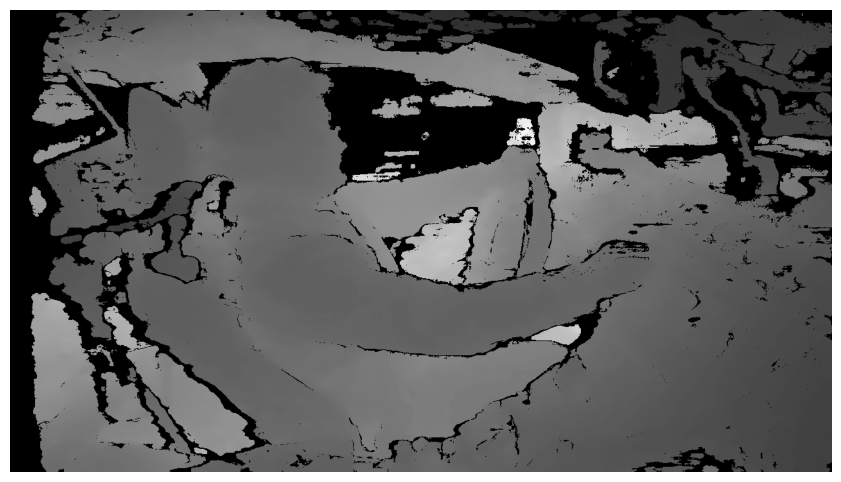

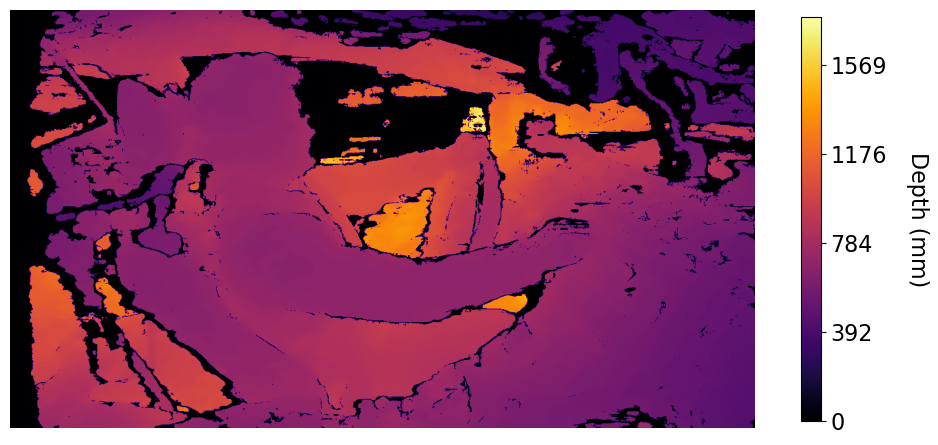

In [8]:
input_video_path = (
    ROOT
    / 'gA_1_s1_2019-03-08T09;31;15+01;00'
    / 'gA_1_s1_2019-03-08T09;31;15+01;00_depth_body.avi'
)
assert input_video_path.exists()

cap = cv2.VideoCapture(str(input_video_path))
cap.set(cv2.CAP_PROP_CONVERT_RGB, 0)  # Disable RGB conversion
cap.set(cv2.CAP_PROP_POS_FRAMES, 653)
ret, frame = cap.read()
cap.release()

print(frame.min(), frame.max(), frame.dtype, frame.shape)

# Define the threshold (e.g. 2000 mm for 2 meters)
depth_threshold = 2000

# Clip the depth values so that any value above the threshold is set to the threshold
# img_clipped = np.clip(frame, 0, depth_threshold)
img_clipped = np.where(frame > depth_threshold, 0, frame)

# Map the range [0, depth_threshold] to [0, 255]
img8 = ((img_clipped / depth_threshold) * 255).astype(np.uint8)

plt.figure(figsize=(11, 6))
plt.imshow(img8, cmap='gray')
plt.axis('off')
plt.show()


def tick_formatter(x: Any, pos: Any) -> str:
    """Formatter function that scales tick values from 0-255 to 0-2000"""
    return f'{int(round(x * 2000 / 255))}'


plt.figure(figsize=(12, 7))
plt.imshow(img8, cmap=plt.cm.inferno)  # type: ignore

cbar = plt.colorbar(shrink=0.75)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
cbar.set_label('Depth (mm)', rotation=270, labelpad=30)

plt.axis('off')
plt.show()